In [ ]:
# Import important libraries
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report
import gdown
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout, TimeDistributed
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Reshape
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D, Embedding
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Constants
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Downloading And Loading the dataset

In [ ]:
# Google Drive file_ids of commercial and non-commercial audio-video features
commercialFeatures_150_file_id          = "1ucT-jrkmhRHx8RSMW0bueGD2IjL3ZpiO"
nonCommercialFeatures_150_file_id       = "1uA5sdu_5b2l0z8k_aI0NeG2eqWsdX9zi"

# Destination paths
commercialFeatures_150_destination      = "commercialFeatures_150.pkl"
nonCommercialFeatures_150_destination   = "nonCommercialFeatures_150.pkl"

In [ ]:
def download_file_from_google_drive(file_id, destination):
    """
    Download a file from Google Drive if it doesn't already exist locally.

    Parameters:
    - file_id (str): The unique file ID from Google Drive.
    - destination (str): The local path where the file should be saved.
    """
    if os.path.exists(destination):
        print(f'File already exists at {destination}. Skipping download.')
    else:
        url = f"https://drive.google.com/uc?id={file_id}"
        gdown.download(url, destination, quiet=False)

In [ ]:
# Downloading commercialFeatures
download_file_from_google_drive(commercialFeatures_150_file_id, commercialFeatures_150_destination)

# Downloading nonCommercialFeatures
download_file_from_google_drive(nonCommercialFeatures_150_file_id, nonCommercialFeatures_150_destination)

File already exists at commercialFeatures_150.pkl. Skipping download.
File already exists at nonCommercialFeatures_150.pkl. Skipping download.


In [ ]:
def load_features():
    """
    Load data from a pickled file if it exists, otherwise initialize an empty list.

    Returns:
    - commercialFeatures_150 (list) - List containing Commercial video features
    - nonCommercialFeatures_150 (list) - List containing nonCommercial video features
    """
    with open('commercialFeatures_150.pkl', 'rb') as f:
        commercialFeatures_150 = pickle.load(f)
    with open('nonCommercialFeatures_150.pkl', 'rb') as f:
        nonCommercialFeatures_150 = pickle.load(f)
    # # Move tensors to GPU explicitly
    # with tf.device('/GPU:0'):
    #     commercialFeatures_150_tensor_gpu = tf.convert_to_tensor(commercialFeatures_150, dtype=tf.float64)
    #     nonCommercialFeatures_150_tensor_gpu = tf.convert_to_tensor(nonCommercialFeatures_150, dtype=tf.float64)
    print(f'Number of commercial features: {len(commercialFeatures_150)}')
    print(f'Number of nonCommercial features: {len(nonCommercialFeatures_150)}')
    print("Audio-Visual Features Loaded Successfully")
    return commercialFeatures_150, nonCommercialFeatures_150

In [ ]:
commercialFeatures_150, nonCommercialFeatures_150 = load_features()

Number of commercial features: 4364
Number of nonCommercial features: 4597
Audio-Visual Features Loaded Successfully


In [ ]:
print(commercialFeatures_150.shape)

(4364, 150, 1152)


In [ ]:
print(nonCommercialFeatures_150.shape)

(4597, 150, 1152)


# Generating labels for data and merging commercial and non-commercial features and shuffling data randomly

In [ ]:
# Generating labels
commercial_labels = np.ones(len(commercialFeatures_150))
non_commercial_labels = np.zeros(len(nonCommercialFeatures_150))

In [ ]:
# Merging commercial and non-commercial features
X = np.concatenate((commercialFeatures_150, nonCommercialFeatures_150), axis=0)
Y = np.concatenate((commercial_labels, non_commercial_labels), axis=0)

In [ ]:
print(f'Shape of data is {X.shape}')
print(f'Shape of labels is {Y.shape}')

Shape of data is (8961, 150, 1152)
Shape of labels is (8961,)


In [ ]:
# Shuffling data randomly
X, Y = shuffle(X, Y, random_state=42)

# Preprocess the data

In [ ]:
print(X[0][0])

[219.  78. 255. ... 124. 141. 177.]


In [ ]:
# Finding Range of data
maxi = 0
mini = 1000
for i in range(len(X[0][0])):
    maxi = max(maxi, X[0][0][i])
    mini = min(mini, X[0][0][i])

In [ ]:
print(f'maximum value is {maxi}')
print(f'minimum value is {mini}')

maximum value is 255.0
minimum value is 0.0


In [ ]:
def scale_data(data):
    """
    Scale the input data by dividing by 255.

    Parameters:
    data (numpy.ndarray): Input data array of shape [samples, features] or higher dimensions.

    Returns:
    numpy.ndarray: Scaled data with values in the range [0, 1].
    """

    scaled_data = data / 255.0
    return scaled_data

In [ ]:
X = scale_data(X)

In [ ]:
print(X[0][0])

[0.85882353 0.30588235 1.         ... 0.48627451 0.55294118 0.69411765]


In [ ]:
def standardize_data(data):
    """
    Standardize the input data.

    Parameters:
    data (numpy.ndarray): Input data array of shape [samples, features] or higher dimensions.
                          If the input has more than 2 dimensions, the function will flatten the
                          data along the features axis, standardize, and then reshape back.

    Returns:
    numpy.ndarray: Standardized data with mean 0 and standard deviation 1 along the features axis.
    """

    original_shape = data.shape
    if len(original_shape) > 2:
        data = data.reshape(-1, original_shape[-1])

    scaler = StandardScaler()
    standardized_data = scaler.fit_transform(data)

    if len(original_shape) > 2:
        standardized_data = standardized_data.reshape(original_shape)

    return standardized_data

In [ ]:
X = standardize_data(X)

In [ ]:
print(X[0][0])

[ 1.55840786 -0.51457659  3.16766892 ...  0.02947117  0.20901008
  0.56678746]


# Train, Test and Validation split

In [ ]:
def split_data(data, labels, train_ratio=0.7, valid_ratio=0.15, test_ratio=0.15, random_state=None):
    """
    Split data into training, validation, and test sets.

    Parameters:
    data (numpy.ndarray): The input data of shape [samples, features].
    labels (numpy.ndarray): The corresponding labels of shape [samples,].
    train_ratio (float): The ratio of the training set. Default is 0.7.
    valid_ratio (float): The ratio of the validation set. Default is 0.15.
    test_ratio (float): The ratio of the test set. Default is 0.15.
    random_state (int, optional): Random seed for reproducibility.

    Returns:
    tuple: Tuple containing:
        - train_data (numpy.ndarray): Training data.
        - valid_data (numpy.ndarray): Validation data.
        - test_data (numpy.ndarray): Test data.
        - train_labels (numpy.ndarray): Training labels.
        - valid_labels (numpy.ndarray): Validation labels.
        - test_labels (numpy.ndarray): Test labels.
    """

    assert train_ratio + valid_ratio + test_ratio == 1, "Ratios must sum to 1."

    train_data, temp_data, train_labels, temp_labels = train_test_split(
        data, labels, test_size=(1 - train_ratio), random_state=random_state
    )

    temp_ratio = valid_ratio + test_ratio
    valid_ratio_relative = valid_ratio / temp_ratio
    test_ratio_relative = test_ratio / temp_ratio

    valid_data, test_data, valid_labels, test_labels = train_test_split(
        temp_data, temp_labels, test_size=test_ratio_relative, random_state=random_state
    )

    return train_data, valid_data, test_data, train_labels, valid_labels, test_labels

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, Y, random_state=42)


In [ ]:
del X
del Y
del commercialFeatures_150
del nonCommercialFeatures_150
del commercial_labels
del non_commercial_labels

In [ ]:
print(f'Train data shape: {X_train.shape}')
print(f'Validation data shape: {X_val.shape}')
print(f'Test data shape: {X_test.shape}')

Train data shape: (6272, 150, 1152)
Validation data shape: (1344, 150, 1152)
Test data shape: (1345, 150, 1152)


In [ ]:
print(f'Train labels shape: {y_train.shape}')
print(f'Validation labels shape: {y_val.shape}')
print(f'Test labels shape: {y_test.shape}')

Train labels shape: (6272,)
Validation labels shape: (1344,)
Test labels shape: (1345,)


# CNNs Model

In [ ]:
def cnn_model(input_shape):
    model = Sequential()

    model.add(Reshape((input_shape[0], input_shape[1], 1), input_shape=input_shape))

    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
input_shape = (150, 1152)
cnn_model = cnn_model(input_shape)
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 150, 1152, 1)      0         
                                                                 
 conv2d (Conv2D)             (None, 150, 1152, 32)     320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 576, 32)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 576, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 37, 288, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 288, 128)      7

## Model training

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
history = cnn_model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=8,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)

Epoch 1/20
196/196 [==============================] - 37s 137ms/step - loss: 0.6658 - accuracy: 0.7342 - val_loss: 0.2234 - val_accuracy: 0.9286
Epoch 2/20
196/196 [==============================] - 25s 125ms/step - loss: 0.2295 - accuracy: 0.9198 - val_loss: 0.2117 - val_accuracy: 0.9241
Epoch 3/20
196/196 [==============================] - 25s 126ms/step - loss: 0.1754 - accuracy: 0.9362 - val_loss: 0.2028 - val_accuracy: 0.9256
Epoch 4/20
196/196 [==============================] - 25s 126ms/step - loss: 0.1344 - accuracy: 0.9539 - val_loss: 0.1924 - val_accuracy: 0.9345
Epoch 5/20
196/196 [==============================] - 25s 125ms/step - loss: 0.1032 - accuracy: 0.9592 - val_loss: 0.2139 - val_accuracy: 0.9405
Epoch 6/20
196/196 [==============================] - 24s 125ms/step - loss: 0.0849 - accuracy: 0.9678 - val_loss: 0.2756 - val_accuracy: 0.9211
Epoch 7/20
196/196 [==============================] - 25s 126ms/step - loss: 0.0739 - accuracy: 0.9716 - val_loss: 0.2231 - val_ac

## Model Evaluation

In [ ]:
test_loss, test_accuracy = cnn_model.evaluate(X_test, y_test)

43/43 [==============================] - 2s 41ms/step - loss: 0.1733 - accuracy: 0.9390


In [ ]:
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

Test Loss: 0.17330396175384521
Test Accuracy: 0.9390334486961365


In [ ]:
y_pred = (cnn_model.predict(X_test) > 0.5).astype("int32")

43/43 [==============================] - 2s 37ms/step


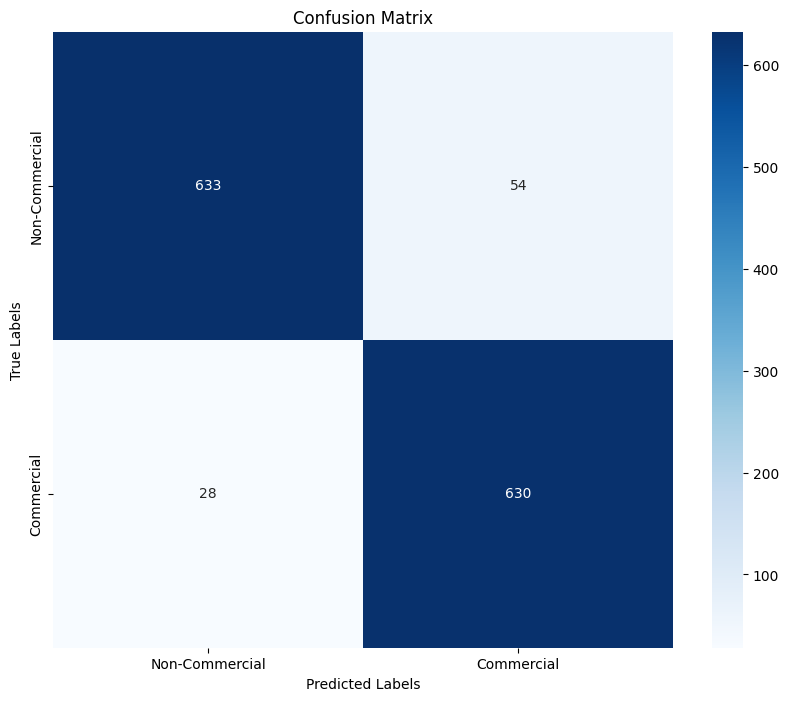

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Commercial', 'Commercial'], yticklabels=['Non-Commercial', 'Commercial'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## Converting the Trained CNN model to .tflite format

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(cnn_model)
tflite_model = converter.convert()

In [ ]:
# Save the converted model
with open('cnn_model.tflite', 'wb') as f:
    f.write(tflite_model)

## Inferencing on .tflite model

In [ ]:
# Load the TFLite model and allocate tensors
interpreter = tf.lite.Interpreter(model_path='./cnn_model.tflite')
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [ ]:
def run_inference(input_data):
    """
    Run inference on a single input using the TensorFlow Lite interpreter.

    Parameters:
    input_data (np.ndarray): The input data for the model. Should be a NumPy array with the appropriate shape.

    Returns
    output_data (np.ndarray): The output data from the model. The shape and type of this output depend on the model's architecture.
    """
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    return output_data


In [ ]:
def evaluate_model(interpreter, X_test, y_test, threshold=0.5):
    """
    Evaluate the TensorFlow Lite model on the given test dataset.

    Parameters
    interpreter (tf.lite.Interpreter): The TensorFlow Lite interpreter for running inference.
    X_test (np.ndarray): The test dataset input features. Should be a NumPy array of shape (n_samples, seq_len, n_features).
    y_test (np.ndarray): The test dataset labels. Should be a NumPy array of shape (n_samples,).
    threshold (float, optional): he threshold for binary classification. Default is 0.5.

    Returns
    accuracy (float): The accuracy of the model on the test dataset.
    """
    correct_predictions = 0
    total_predictions = 0

    for i in range(len(X_test)):
        input_data = np.expand_dims(X_test[i], axis=0).astype(np.float32)  # Adding batch dimension
        predicted_output = run_inference(input_data)
        predicted_label = (predicted_output >= threshold).astype(int)[0][0]  # Applying threshold
        true_label = y_test[i]

        if predicted_label == true_label:
            correct_predictions += 1
        total_predictions += 1

    accuracy = correct_predictions / total_predictions
    return accuracy

In [ ]:
accuracy = evaluate_model(interpreter, X_test, y_test)
print(f'Accuracy: {accuracy}')

Accuracy: 0.9390334572490706
